In [19]:
import numpy as np
import pandas as pd
import seaborn
import geopandas as gpd
import pysal
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import time
import random
from shapely import wkt
from libpysal.weights import Queen, KNN
import seaborn
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar
from esda.moran import Moran_Local_BV, Moran_BV, Moran_Local_BV, Moran, Moran_Local
from splot.esda import plot_local_autocorrelation, plot_moran_bv_simulation, plot_moran_bv, lisa_cluster, moran_scatterplot

In [20]:
gdfjoined = gpd.read_file( r"exported_data/states_sheldus_all.shp")
gdfjoined2 = gdfjoined.to_crs({'init':'epsg:4326'})
gdfjoined2.crs

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
gdfjoined2.head()

,STATE,STATEABBRV,COUNTY,COUNTYFIPS,STCOFIPS,POPULATION,BUILDVALUE,AGRIVALUE,SOVI_SCORE,RESL_VALUE,...,HAtotal,HAcount,PAcount,SBAcount,SBAProjcou,SBAapprove,HazardCoun,x,y,geometry
0,Alabama,AL,Autauga,001,01001,58764,9.123274e+09,24613998.0,51.299999,2.604995,...,1.344949e+07,7.0,0.0,118.0,12.0,3.033300e+06,24.0,-9.645027e+06,3.833755e+06,"POLYGON ((-86.41284 32.63589, -86.41279 32.625..."
1,Alabama,AL,Baldwin,003,01003,231365,4.596848e+10,138089013.0,31.030001,2.745075,...,1.237589e+10,128.0,0.0,3842.0,131.0,1.770457e+09,164.0,-9.765332e+06,3.598722e+06,"MULTIPOLYGON (((-87.92666 30.66002, -87.92688 ..."
2,Alabama,AL,Barbour,005,01005,25160,4.847697e+09,121075758.0,99.269997,2.383568,...,4.351235e+05,3.0,0.0,38.0,3.0,2.096000e+05,22.0,-9.505916e+06,3.746245e+06,"POLYGON ((-85.25954 32.13837, -85.25882 32.138..."
3,Alabama,AL,Bibb,007,01007,22239,3.146947e+09,4819356.0,80.779999,2.471525,...,2.672808e+07,7.0,0.0,82.0,7.0,5.044600e+06,20.0,-9.698871e+06,3.895149e+06,"POLYGON ((-87.02581 33.21717, -87.02573 33.209..."
4,Alabama,AL,Blount,009,01009,58992,7.815620e+09,278570859.0,51.369999,2.488382,...,1.062727e+08,9.0,0.0,138.0,16.0,2.816300e+07,27.0,-9.636627e+06,4.026266e+06,"POLYGON ((-86.44414 34.25913, -86.44434 34.256..."


In [22]:
gdfjoined2['totalAssist']   = gdfjoined2['HMAprojAmo']  + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal'] + gdfjoined2['SBAapprove'] 
gdfjoined2['totalAssist3']  = gdfjoined2['HMAprojAmo']  + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal']
gdfjoined2['totalDamage']   = gdfjoined2['CropDmg']     + gdfjoined2['PropertyDm'] 
gdfjoined2['DamageSOVI']    = gdfjoined2['HazardCoun']  * gdfjoined2['SOVI_SCORE'] 


In [23]:
print( gdfjoined2.total_bounds )
xmin, ymin, xmax, ymax = [-125.78, 22.25, -65.62, 50.48]

[-124.7541084    24.52108866  -66.95000492   49.38435908]


In [24]:
print( gdfjoined2.columns )
new_splited_col        = gdfjoined2["NAME"].str.split(",", n = 1, expand = True)
gdfjoined2["cbsa"]     = new_splited_col[0]

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'NumPropert', 'CropDmg', 'CropDmg21',
       'CropDmgPer', 'PropertyDm', 'ProDmg21', 'ProDmgPerC', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'totalAssist', 'totalAssist3',
       'totalDamage', 'DamageSOVI'],
      dtype='object')


In [25]:
gdfjoined2['totalDamage2']  = np.log( gdfjoined2['totalDamage'] +1)

gdfjoined2['HMAprojAmo2']    = np.log( gdfjoined2['HMAprojAmo']  + 1)
gdfjoined2['PAprojectA2']    = np.log( gdfjoined2['PAprojectA'] + 1)
gdfjoined2['PDMprojAmo2']    = np.log( gdfjoined2['PDMprojAmo'] + 1)
gdfjoined2['HAtotal2']       = np.log( gdfjoined2['HAtotal'] + 1)
gdfjoined2['SBAapprove2']    = np.log( gdfjoined2['SBAapprove'] + 1)

In [26]:
y1 = gdfjoined2[ 'HMAprojAmo2' ].values
w1 = Queen.from_dataframe( gdfjoined2 )

w1.transform = 'r'
x1 = (gdfjoined2['totalDamage2'] ).values
moran_loc_bv1 = Moran_Local_BV( x1, y1, w1)

gdfjoined2['label1']    = moran_loc_bv1.q
gdfjoined2['x1']        = moran_loc_bv1.p_sim
gdfjoined2['p_sim1']    = moran_loc_bv1.p_sim
gdfjoined2['Moran1']    = moran_loc_bv1.Is

gdfjoined2.loc[ gdfjoined2['x1'] >= 0.05 ,'label1'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2["color1"] = gdfjoined2["label1"].map( color_mapping )

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


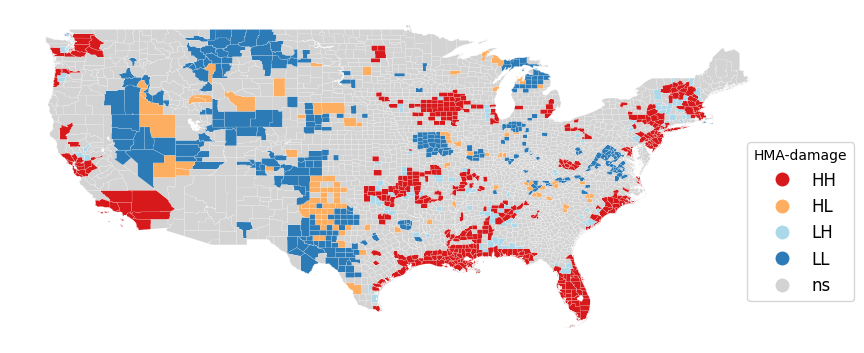

In [27]:
lisa_cluster(moran_loc_bv1, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right', 'title': "HMA-damage", 
                          'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12) )
plt.show()

In [28]:
y2 = gdfjoined2['SBAapprove2'] 
x2 = gdfjoined2[ 'totalDamage2' ].values 
moran_loc_bv2 = Moran_Local_BV(x2, y2, w1)

gdfjoined2['label2'] = moran_loc_bv2.q
gdfjoined2['x2'] = moran_loc_bv2.p_sim
gdfjoined2['p_sim2'] = moran_loc_bv2.p_sim
gdfjoined2['Moran2']    = moran_loc_bv2.Is

gdfjoined2.loc[ gdfjoined2['x2'] >= 0.05 ,'label2'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2["color2"] = gdfjoined2["label2"].map( color_mapping )


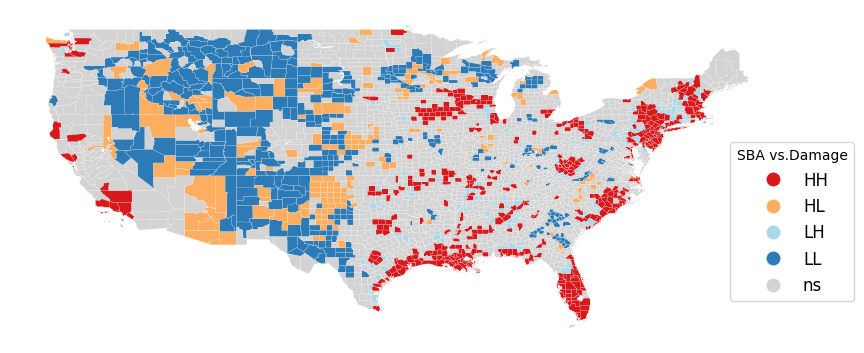

In [29]:
lisa_cluster(moran_loc_bv2, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  
                          'title': "SBA vs.Damage", 'bbox_to_anchor': (1.1, 0.1),
                          'fontsize':'large' }, figsize=(10, 12) )
plt.show()

In [30]:
y3 = gdfjoined2['HAtotal2']
x3 = gdfjoined2['totalDamage2'].values
moran_loc_bv3 = Moran_Local_BV(x3, y3, w1)

gdfjoined2['label3'] = moran_loc_bv3.q
gdfjoined2['x3'] = moran_loc_bv3.p_sim
gdfjoined2['p_sim3'] = moran_loc_bv3.p_sim
gdfjoined2['Moran3']    = moran_loc_bv3.Is

gdfjoined2.loc[ gdfjoined2['x3'] >= 0.05 ,'label3'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2["color3"] = gdfjoined2["label3"].map( color_mapping )


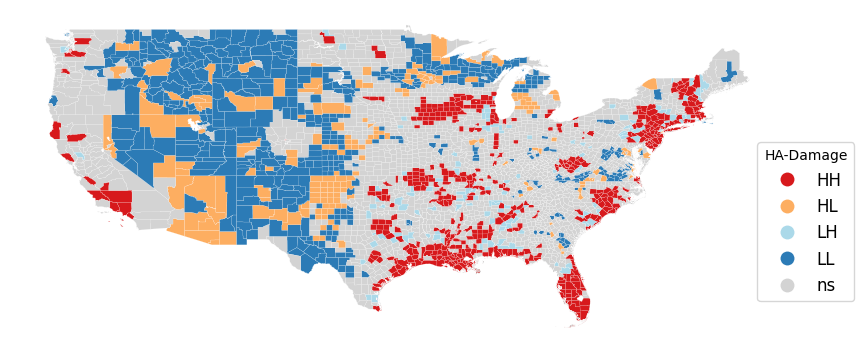

In [31]:
lisa_cluster(moran_loc_bv3, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  
                          'title': "HA-Damage", 
                          'bbox_to_anchor': (1.1, 0.1),
                          'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [32]:
y4 = ( gdfjoined2['PAprojectA2'] ).values 

x4 = gdfjoined2['totalDamage2'].values
moran_loc_bv4 = Moran_Local_BV(x4, y4, w1)

gdfjoined2['label4'] = moran_loc_bv4.q
gdfjoined2['x4'] = moran_loc_bv4.p_sim
gdfjoined2['p_sim4'] = moran_loc_bv4.p_sim
gdfjoined2['Moran4']    = moran_loc_bv4.Is


gdfjoined2.loc[ gdfjoined2['x4'] >= 0.05 ,'label4'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2["color4"] = gdfjoined2["label4"].map( color_mapping )


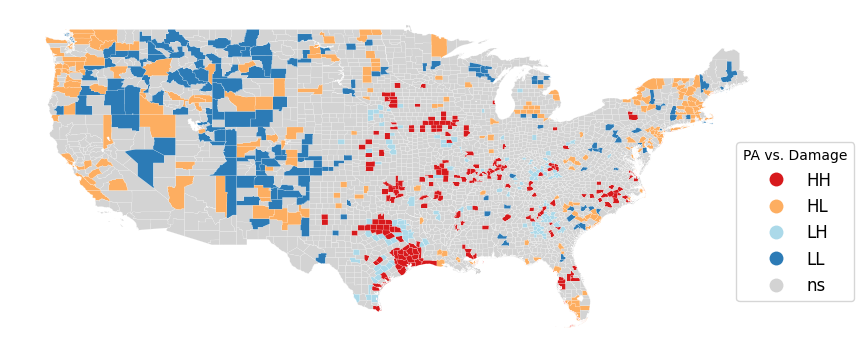

In [33]:
lisa_cluster(moran_loc_bv4, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "PA vs. Damage", 
                          'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' },
                          figsize=(10, 12), )
plt.show()

In [34]:
y5 = ( gdfjoined2['PDMprojAmo2'] ).values

x5 = gdfjoined2['totalDamage2'].values 
moran_loc_bv5 = Moran_Local_BV(x5, y5, w1)

gdfjoined2['label5'] = moran_loc_bv5.q
gdfjoined2['x5'] = moran_loc_bv5.p_sim
gdfjoined2['p_sim5'] = moran_loc_bv5.p_sim
gdfjoined2['Moran5']    = moran_loc_bv5.Is


gdfjoined2.loc[ gdfjoined2['x5'] >= 0.05 ,'label5'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2['color5'] = gdfjoined2['label5'].map( color_mapping )


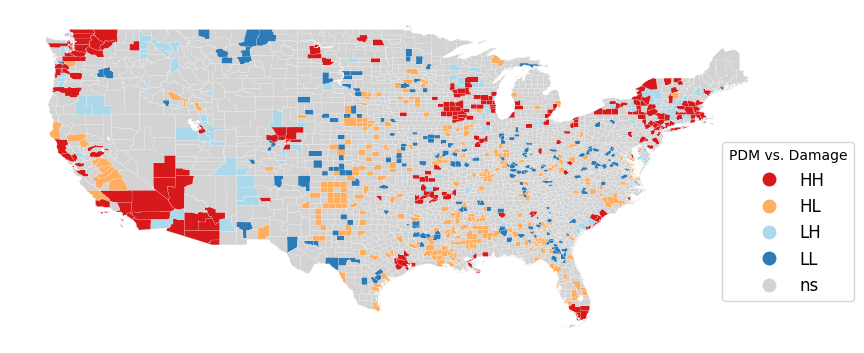

In [35]:
lisa_cluster(moran_loc_bv5, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "PDM vs. Damage", 
             'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [36]:
y12 = ( gdfjoined2['HMAprojAmo2'] ).values
w12 = Queen.from_dataframe( gdfjoined2 )

w12.transform = 'r'
x12 = gdfjoined2['SOVI_SCORE'].values 
moran_loc_bv12 = Moran_Local_BV(x12, y12, w12)

gdfjoined2['label6'] = moran_loc_bv12.q
gdfjoined2['x6'] = moran_loc_bv12.p_sim
gdfjoined2['p_sim6'] = moran_loc_bv12.p_sim
gdfjoined2['Moran6']    = moran_loc_bv12.Is

gdfjoined2.loc[ gdfjoined2['x6'] >= 0.05 ,'label6'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2['color6'] = gdfjoined2['label6'].map( color_mapping )

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


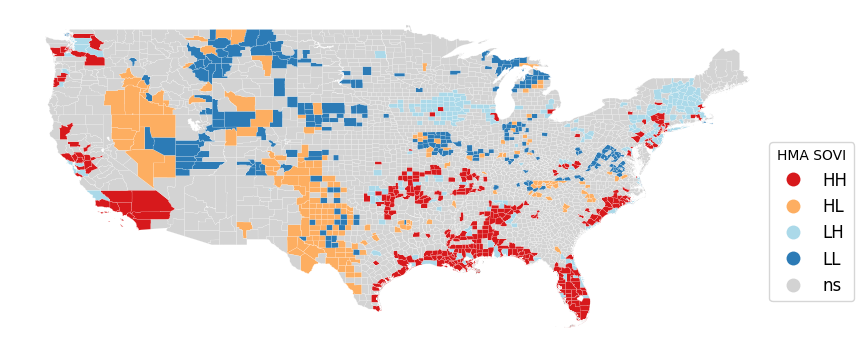

In [37]:
lisa_cluster(moran_loc_bv12, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "HMA SOVI", 
             'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [38]:
y22  = gdfjoined2['SBAapprove2'] 
x22  = gdfjoined2[ 'SOVI_SCORE' ].values
moran_loc_bv22  = Moran_Local_BV(x22, y22, w12)

gdfjoined2['label7']    = moran_loc_bv22.q
gdfjoined2['x7']         = moran_loc_bv22.p_sim
gdfjoined2['p_sim7']  = moran_loc_bv22.p_sim
gdfjoined2['Moran7']    = moran_loc_bv22.Is

gdfjoined2.loc[ gdfjoined2['x7'] >= 0.05 , 'label7'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2['color7'] = gdfjoined2['label7'].map( color_mapping )

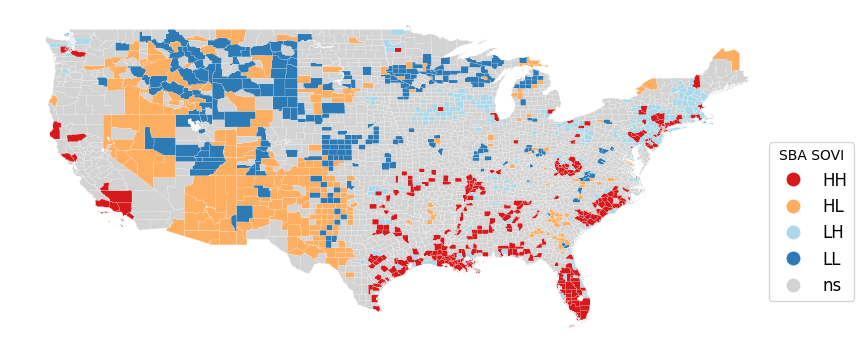

In [39]:
lisa_cluster(moran_loc_bv22, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "SBA SOVI", 
                          'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [40]:
y32 = gdfjoined2[ 'HAtotal2' ] 
x32 = gdfjoined2[ 'SOVI_SCORE' ].values 
moran_loc_bv32 = Moran_Local_BV(x32, y32, w12)

gdfjoined2[ 'label8' ] = moran_loc_bv32.q
gdfjoined2[ 'x8' ] = moran_loc_bv32.p_sim
gdfjoined2[ 'p_sim8' ] = moran_loc_bv32.p_sim
gdfjoined2['Moran8']    = moran_loc_bv32.Is

gdfjoined2.loc[ gdfjoined2['x8'] >= 0.05 ,'label8'] = 0
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2[ 'color8' ] = gdfjoined2[ 'label8' ].map( color_mapping )


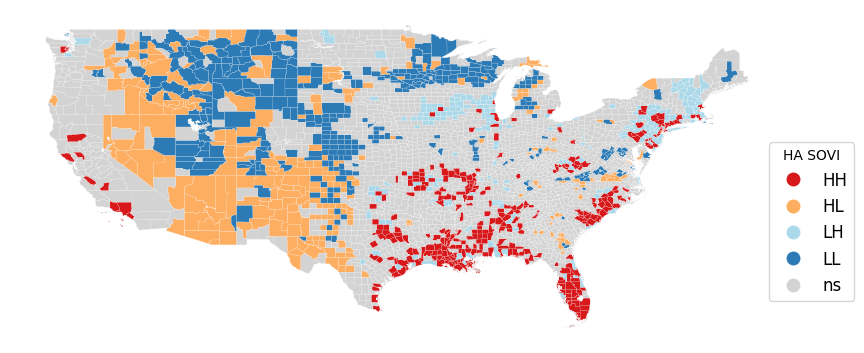

In [41]:
lisa_cluster(moran_loc_bv32, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "HA SOVI", 
                          'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12) )
plt.show()

In [42]:
y42 = ( gdfjoined2['PAprojectA2'] ).values

x42 = gdfjoined2['SOVI_SCORE'].values 
moran_loc_bv42 = Moran_Local_BV(x42, y42, w12)

gdfjoined2['label9'] = moran_loc_bv42.q
gdfjoined2['x9'] = moran_loc_bv42.p_sim
gdfjoined2['p_sim9'] = moran_loc_bv42.p_sim
gdfjoined2['Moran9']    = moran_loc_bv42.Is


color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2.loc[ gdfjoined2['x9'] >= 0.05 ,'label9'] = 0
gdfjoined2['color9'] = gdfjoined2["label9"].map( color_mapping )


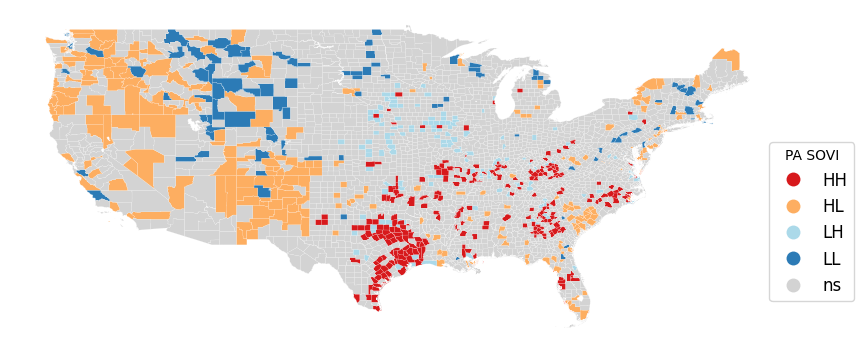

In [43]:
lisa_cluster(moran_loc_bv42, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "PA SOVI", 
                          'bbox_to_anchor': (1.1, 0.1), 'fontsize':'large' }, figsize=(10, 12) )
plt.show()

In [44]:
y52 = ( gdfjoined2['PDMprojAmo2'] ).values 
x52 = gdfjoined2['SOVI_SCORE'].values
moran_loc_bv52 = Moran_Local_BV(x52, y52, w12)

gdfjoined2['label10'] = moran_loc_bv52.q
gdfjoined2['x10'] = moran_loc_bv52.p_sim
gdfjoined2['p_sim10'] = moran_loc_bv52.p_sim
gdfjoined2['Moran10']    = moran_loc_bv52.Is

color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2.loc[ gdfjoined2['x10'] >= 0.05 ,'label10'] = 0
gdfjoined2['color10'] = gdfjoined2["label10"].map( color_mapping )


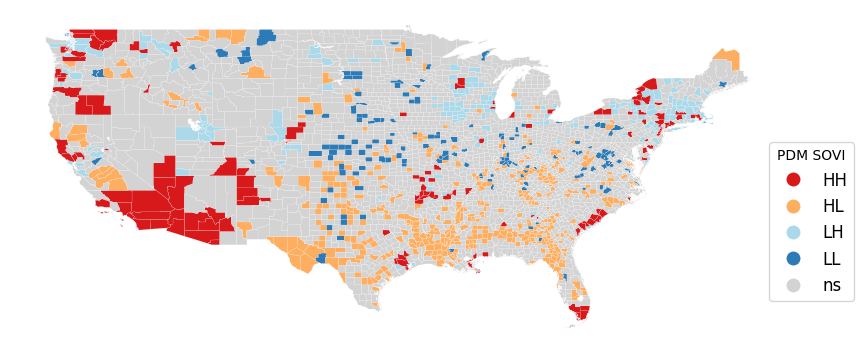

In [45]:
lisa_cluster(moran_loc_bv52, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "PDM SOVI", 
                                                                'bbox_to_anchor': (1.1, 0.1),
                                                                'fontsize':'large' },
                                                                 figsize=(10, 12), )
plt.show()

In [120]:
gdfjoined2.columns

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE',
       ...
       'label9', 'x9', 'p_sim9', 'Moran9', 'color9', 'label10', 'x10',
       'p_sim10', 'Moran10', 'color10'],
      dtype='object', length=103)

In [46]:
gdfjoined2 = gpd.GeoDataFrame( gdfjoined2, geometry = 'geometry', crs="EPSG:4326")
gdfjoined2.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/fema_projects_localMorans_all.shp")

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_4846/4002027283.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfjoined2.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/fema_projects_localMorans_all.shp")


In [36]:
print( gdfjoined2.label2.unique() )

[0 2 1 3]


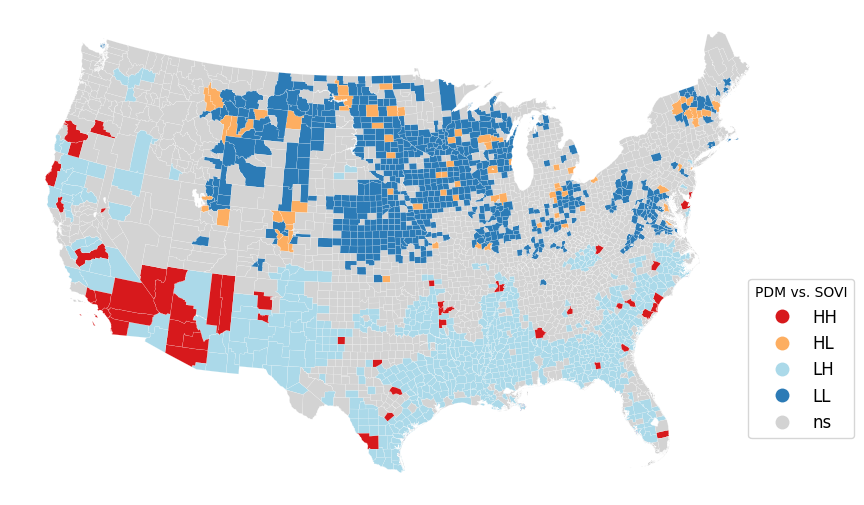

In [115]:

lisa_cluster(moran_loc_bv52, gdfjoined, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "PDM vs. SOVI", 
                                                                'bbox_to_anchor': (1.1, 0.1),
                                                                'fontsize':'large' },
                                                                 figsize=(10, 12), )
plt.show()